In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

2023-04-26 11:34:19.284758: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-26 11:34:19.284777: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Dataset preparation

Dataset downloaded from: https://www.kaggle.com/datasets/patriciabrezeanu/big-cats-image-classification-dataset?resource=download

## Reading color images

In [2]:
#import splitfolders 
#splitfolders.ratio('animals', output="output", seed=1337, ratio=(.8, 0.2))

In [3]:
labels = ['cheetah', 'leopard', 'lion', 'tiger']
img_size = 512

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
color_train = get_data('output/train')
color_val = get_data('output/val')

/tmp/ipykernel_15386/2378813345.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


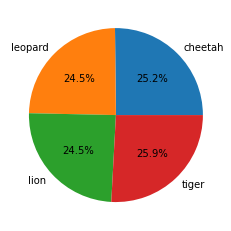

(588, 2)


In [5]:
y = np.array([np.count_nonzero(color_train[:,1] == 0), np.count_nonzero(color_train[:,1] == 1), np.count_nonzero(color_train[:,1] == 2), np.count_nonzero(color_train[:,1] == 3)])
plt.pie(y, labels = labels, autopct='%1.1f%%')
plt.show() 

print(color_train.shape)

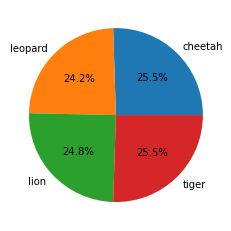

(149, 2)


In [6]:
y = np.array([np.count_nonzero(color_val[:,1] == 0), np.count_nonzero(color_val[:,1] == 1), np.count_nonzero(color_val[:,1] == 2), np.count_nonzero(color_val[:,1] == 3)])
plt.pie(y, labels = labels, autopct='%1.1f%%')
plt.show() 

print(color_val.shape)

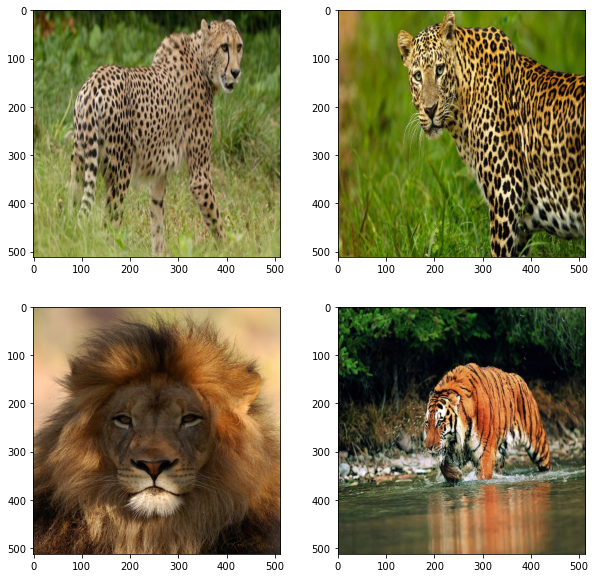

In [7]:
rows=2
cols = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

axes[0, 0].imshow(color_train[1][0])
axes[0, 1].imshow(color_train[160][0])
axes[1, 0].imshow(color_train[300][0])
axes[1, 1].imshow(color_train[450][0])


# Grayscale image preparation

In [8]:
def get_gray_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                gray = cv2.cvtColor(resized_arr, cv2.COLOR_BGR2GRAY)
                data.append([gray, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [9]:
gray_train = get_gray_data('output/train')
gray_val = get_gray_data('output/val')

/tmp/ipykernel_15386/109414422.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


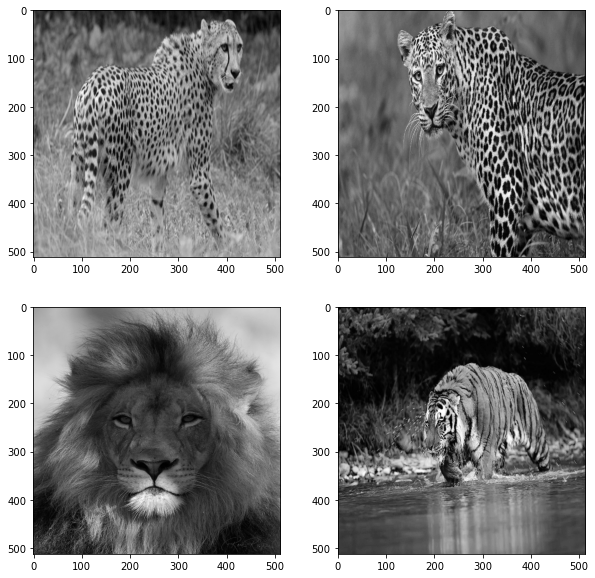

In [10]:
rows=2
cols = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

axes[0, 0].imshow(gray_train[1][0], cmap='gray')
axes[0, 1].imshow(gray_train[160][0], cmap='gray')
axes[1, 0].imshow(gray_train[300][0], cmap='gray')
axes[1, 1].imshow(gray_train[450][0], cmap='gray')

# Noise filtering

In [11]:
def get_gray_filtered_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                gray = cv2.cvtColor(resized_arr, cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [12]:
gray_filtered_train = get_gray_filtered_data('output/train')
gray_filtered_val = get_gray_filtered_data('output/val')

/tmp/ipykernel_15386/3179082502.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


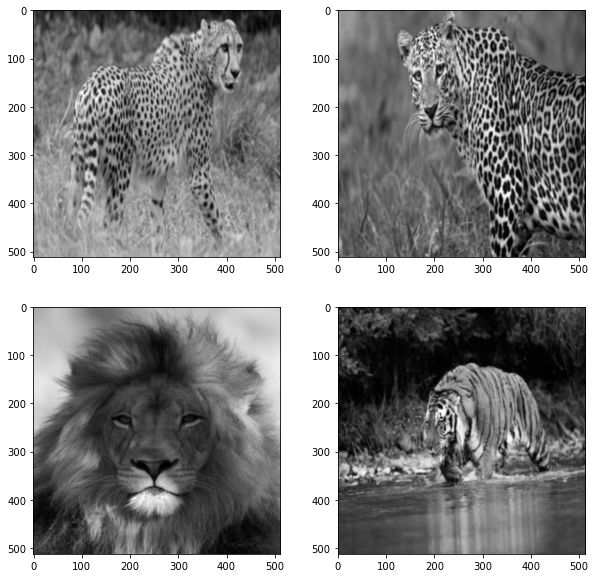

In [13]:
rows=2
cols = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

axes[0, 0].imshow(gray_filtered_train[1][0], cmap='gray')
axes[0, 1].imshow(gray_filtered_train[160][0], cmap='gray')
axes[1, 0].imshow(gray_filtered_train[300][0], cmap='gray')
axes[1, 1].imshow(gray_filtered_train[450][0], cmap='gray')

# Dataset expansion

In [14]:
from skimage.exposure import adjust_gamma

In [15]:
def get_expanded_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                gray = cv2.cvtColor(resized_arr, cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
                
                flipped = tf.image.flip_left_right(resized_arr)
                gray = cv2.cvtColor(np.float32(flipped), cv2.COLOR_RGB2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
                
                flipped = tf.image.flip_up_down(resized_arr)
                gray = cv2.cvtColor(np.float32(flipped), cv2.COLOR_RGB2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
                
                image_dark = adjust_gamma(resized_arr, gamma=2,gain=1)
                gray = cv2.cvtColor(np.float32(image_dark), cv2.COLOR_RGB2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
                
            except Exception as e:
                print(e)
    return np.array(data)

In [16]:
expanded_train = get_expanded_data('output/train')
expanded_val = get_expanded_data('output/val')

2023-04-26 11:35:45.694755: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/arnas/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-04-26 11:35:45.694839: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-26 11:35:45.694880: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arnas-desktop): /proc/driver/nvidia/version does not exist
2023-04-26 11:35:45.695311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_153

In [17]:
print(expanded_train.shape)
print(expanded_val.shape)

(2352, 2)
(596, 2)


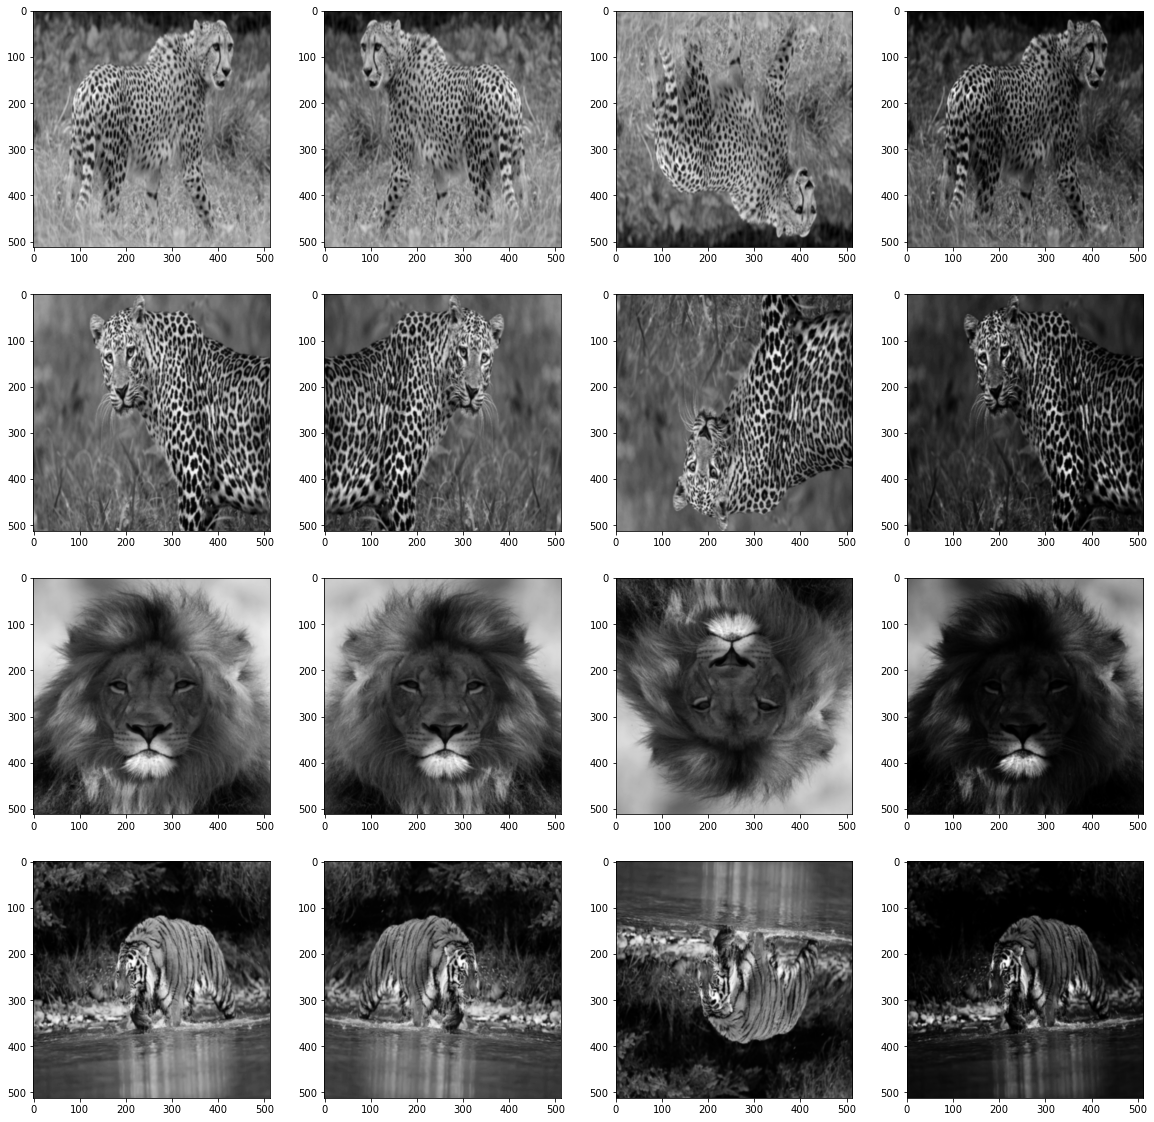

In [18]:
rows=4
cols = 4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))

axes[0, 0].imshow(expanded_train[4][0], cmap='gray')
axes[0, 1].imshow(expanded_train[5][0], cmap='gray')
axes[0, 2].imshow(expanded_train[6][0], cmap='gray')
axes[0, 3].imshow(expanded_train[7][0], cmap='gray')

axes[1, 0].imshow(expanded_train[640][0], cmap='gray')
axes[1, 1].imshow(expanded_train[641][0], cmap='gray')
axes[1, 2].imshow(expanded_train[642][0], cmap='gray')
axes[1, 3].imshow(expanded_train[643][0], cmap='gray')

axes[2, 0].imshow(expanded_train[1200][0], cmap='gray')
axes[2, 1].imshow(expanded_train[1201][0], cmap='gray')
axes[2, 2].imshow(expanded_train[1202][0], cmap='gray')
axes[2, 3].imshow(expanded_train[1203][0], cmap='gray')

axes[3, 0].imshow(expanded_train[1800][0], cmap='gray')
axes[3, 1].imshow(expanded_train[1801][0], cmap='gray')
axes[3, 2].imshow(expanded_train[1802][0], cmap='gray')
axes[3, 3].imshow(expanded_train[1803][0], cmap='gray')

https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/

In [19]:
x_color_train = []
y_color_train = []
x_color_val = []
y_color_val = []

for feature, label in color_train:
  x_color_train.append(feature)
  y_color_train.append(label)

for feature, label in color_val:
  x_color_val.append(feature)
  y_color_val.append(label)

# Normalize the data
x_color_train = np.array(x_color_train) / 255
x_color_val = np.array(x_color_val) / 255

x_color_train.reshape(-1, img_size, img_size, 1)
y_color_train = np.array(y_color_train)

x_color_val.reshape(-1, img_size, img_size, 1)
y_color_val = np.array(y_color_val)



In [20]:
x_gray_train = []
y_gray_train = []
x_gray_val = []
y_gray_val = []

for feature, label in gray_train:
  x_gray_train.append(feature)
  y_gray_train.append(label)

for feature, label in gray_val:
  x_gray_val.append(feature)
  y_gray_val.append(label)

# Normalize the data
x_gray_train = np.array(x_gray_train) / 255
x_gray_val = np.array(x_gray_val) / 255

x_gray_train.reshape(-1, img_size, img_size, 1)
y_gray_train = np.array(y_gray_train)

x_gray_val.reshape(-1, img_size, img_size, 1)
y_gray_val = np.array(y_gray_val)

In [21]:
x_gray_filtered_train = []
y_gray_filtered_train = []
x_gray_filtered_val = []
y_gray_filtered_val = []

for feature, label in gray_filtered_train:
  x_gray_filtered_train.append(feature)
  y_gray_filtered_train.append(label)

for feature, label in gray_filtered_val:
  x_gray_filtered_val.append(feature)
  y_gray_filtered_val.append(label)

# Normalize the data
x_gray_filtered_train = np.array(x_gray_filtered_train) / 255
x_gray_filtered_val = np.array(x_gray_filtered_val) / 255

x_gray_filtered_train.reshape(-1, img_size, img_size, 1)
y_gray_filtered_train = np.array(y_gray_filtered_train)

x_gray_filtered_val.reshape(-1, img_size, img_size, 1)
y_gray_filtered_val = np.array(y_gray_filtered_val)

In [22]:
x_expanded_train = []
y_expanded_train = []
x_expanded_val = []
y_expanded_val = []

for feature, label in expanded_train:
  x_expanded_train.append(feature)
  y_expanded_train.append(label)

for feature, label in expanded_val:
  x_expanded_val.append(feature)
  y_expanded_val.append(label)

# Normalize the data
x_expanded_train = np.array(x_expanded_train) / 255
x_expanded_val = np.array(x_expanded_val) / 255

x_expanded_train.reshape(-1, img_size, img_size, 1)
y_expanded_train = np.array(y_expanded_train)

x_expanded_val.reshape(-1, img_size, img_size, 1)
y_expanded_val = np.array(y_expanded_val)

## Neural network

### Neural network for colour images

In [32]:
modelcolour = Sequential()
modelcolour.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(512,512,3)))
modelcolour.add(MaxPool2D())

modelcolour.add(Conv2D(32, 3, padding="same", activation="relu"))
modelcolour.add(MaxPool2D())

modelcolour.add(Conv2D(64, 3, padding="same", activation="relu"))
modelcolour.add(MaxPool2D())
modelcolour.add(Dropout(0.4))

modelcolour.add(Flatten())
modelcolour.add(Dense(128,activation="relu"))
modelcolour.add(Dense(4, activation="softmax"))

modelcolour.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 512, 512, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 256, 256, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 64)      

### Neural network for gray images

In [33]:
modelgray = Sequential()
modelgray.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(512,512,1)))
modelgray.add(MaxPool2D())

modelgray.add(Conv2D(32, 3, padding="same", activation="relu"))
modelgray.add(MaxPool2D())

modelgray.add(Conv2D(64, 3, padding="same", activation="relu"))
modelgray.add(MaxPool2D())
modelgray.add(Dropout(0.4))

modelgray.add(Flatten())
modelgray.add(Dense(128,activation="relu"))
modelgray.add(Dense(4, activation="softmax"))

modelgray.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 512, 512, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 256, 256, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 64)      

### Models training

In [50]:
opt = Adam(learning_rate=0.0001)
modelcolour.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy() , metrics = ['accuracy'])
modelgray.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy() , metrics = ['accuracy'])

In [51]:
historycolour = modelcolour.fit(x_color_train, y_color_train, batch_size = 16, epochs=20, shuffle = True, validation_split = 0.1)

Epoch 1/50
34/34 [==============================] - 48s 1s/step - loss: 1.4424 - accuracy: 0.3837 - val_loss: 2.4354 - val_accuracy: 0.0000e+00
Epoch 2/50
34/34 [==============================] - 47s 1s/step - loss: 1.1308 - accuracy: 0.5142 - val_loss: 1.4891 - val_accuracy: 0.0000e+00
Epoch 3/50
34/34 [==============================] - 47s 1s/step - loss: 0.9764 - accuracy: 0.5841 - val_loss: 1.3346 - val_accuracy: 0.0000e+00
Epoch 4/50
34/34 [==============================] - 47s 1s/step - loss: 0.8671 - accuracy: 0.6427 - val_loss: 0.9890 - val_accuracy: 0.0508
Epoch 5/50
34/34 [==============================] - 47s 1s/step - loss: 0.8118 - accuracy: 0.6767 - val_loss: 1.3301 - val_accuracy: 0.0508
Epoch 6/50
34/34 [==============================] - 47s 1s/step - loss: 0.7115 - accuracy: 0.7486 - val_loss: 1.2698 - val_accuracy: 0.1356
Epoch 7/50
34/34 [==============================] - 47s 1s/step - loss: 0.6082 - accuracy: 0.7694 - val_loss: 0.9401 - val_accuracy: 0.4576
Epoch 8/

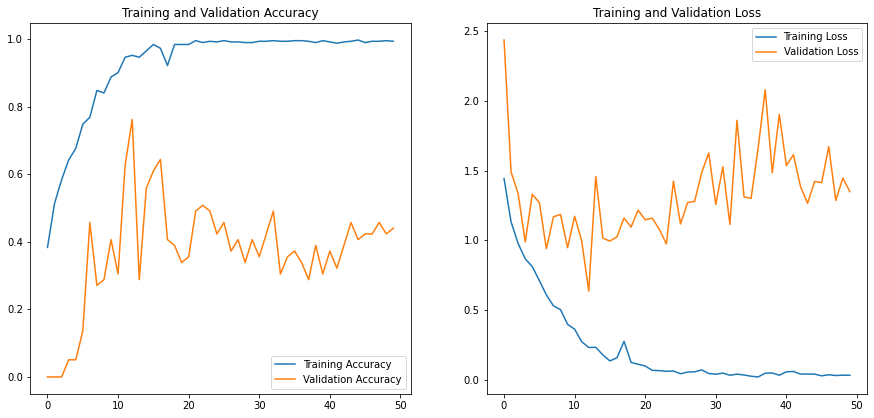

In [52]:
acc = historycolour.history['accuracy']
val_acc = historycolour.history['val_accuracy']
loss = historycolour.history['loss']
val_loss = historycolour.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
def test_accuracy(y_true, y_pred):
    pred = np.sum(y_true == y_pred)
    n = np.size(y_true)
    return pred/n * 100

5/5 [==============================] - 2s 340ms/step
Test accuracy:61.74496644295302%


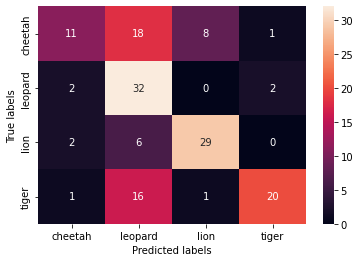

In [55]:
y_pred = modelcolour.predict(x_color_val)

from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(y_color_val, y_pred.argmax(axis=-1))
ax = plt.subplot()
axis_labels = ['cheetah','leopard','lion', 'tiger'] 
sns.heatmap(confusion, xticklabels=axis_labels, yticklabels=axis_labels, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

accuracy = test_accuracy(y_color_val, y_pred.argmax(axis=-1))
print('Test accuracy:' + str(accuracy) + '%')